<a href="https://colab.research.google.com/github/djbrady/invisibleHeadlights/blob/master/DARPAInvisibleHeadlights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DARPA Invisible Headlights Program 

## Infrared Hyperspectral Signal Analysis

## David Brady
## Duke University

## May 2020

## Background

This notebook considers various technical issues arising in the DARPA Invisible Headlights program.

Compressive spectral imaging is a potential mechanism for 3D mapping using ambient signals. This note book explores the type of spectral features one can use for this purpose. 

### Initialization

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA


## System Concept

We propose 3d imaging sensors using differential infrared spectroscopy. This notebook considers


1.   Total power available per pixel as a function of range.
2.   Range Resolution as a function spectral features. 

we assume a 10 cm collection aperture, but a ground sample distance (gsd) of .1 m. Resolving GSD at range R requires a focal length satisfying
$${f/\#\lambda R\over F}<gsd$$
so for gsd=0.1, $f/\#=1.5$, $\lambda=8\mu $ and $R=350$ m, we require $F\approx 50 mm$, which corresponds to a hyperfocal distance of 50 meters. We anticipate using shorter focal length lenses for near-field imaging. An array camera, similar to the Aqueti Pathfinder, can be used to fully resolve the 2-400 meter range.

With a multifocal array camera on a moving vehicle, 3D scene construction can be achieved by triangulation. In parallel to triangulation, with much better staring range resolution, we propose to use depth from spectral analysis. Spectral measurement can be achieved using multiscale CASSI-style cameras. 


In [0]:
1.7*8.*10.**(-6)*350/.1

0.04759999999999999

In [0]:
# hyperfocal distance of imaging lens
f=0.05 # focal length
c=25.*10.**(-6) # circle of confusion
fn=2. # fnumber
hyperfocalDistance=f**2./(fn*c)
print(hyperfocalDistance)

50.000000000000014


## Power per pixel

we asume that typical objects are black body radiators. Accordingly, the power radiated is tive by the stefan-boltzman relationship. For ground target area 10 cm, the radiated power per pixel is give below at 300K

In [0]:
# stefan-boltzman constant
sig= 5.67*10**(-8) # W/(m2K4
h=6.6*10**(-34);
c=3*10**8;
k=1.38064852*10**(-23) #m2 kg s-2 K-1;
def powerRad(gsd,T):
  p=sig*T**4.*gsd
  return p

In [0]:
powerRad(0.1**2,300) # thermal radiation from a .1 m gsd

4.592700000000001

In [0]:
# power per pixel as a function of range, gsd and aperture
def pp(T, gsd, R , aperture):
  pp=((aperture/(2*R))**2)*powerRad(gsd,T)
  return pp

In [0]:
pp(300,.1,350,.1)

9.372857142857144e-07

so we get about 1 microwatt per pixel integrated over all wavelengths. Let's now consider the power sepctral density. According to Plank's law, the power per unit solid angle per unit wavelength per unit source area is

$$S(\lambda, T) ={2hc^2\over \lambda^5}{1\over e^{hc\over\lambda k T}-1}$$


In [0]:
# power spectral density at the detector as a function of gsd, range, aperture
def B(lam,T, gsd, R , aperture):
  bb=((gsd *aperture/R)**2)*(2*h*(c**2)/(lam**5))*(1/(np.exp(h*c/(lam*k*T))-1));
  return bb

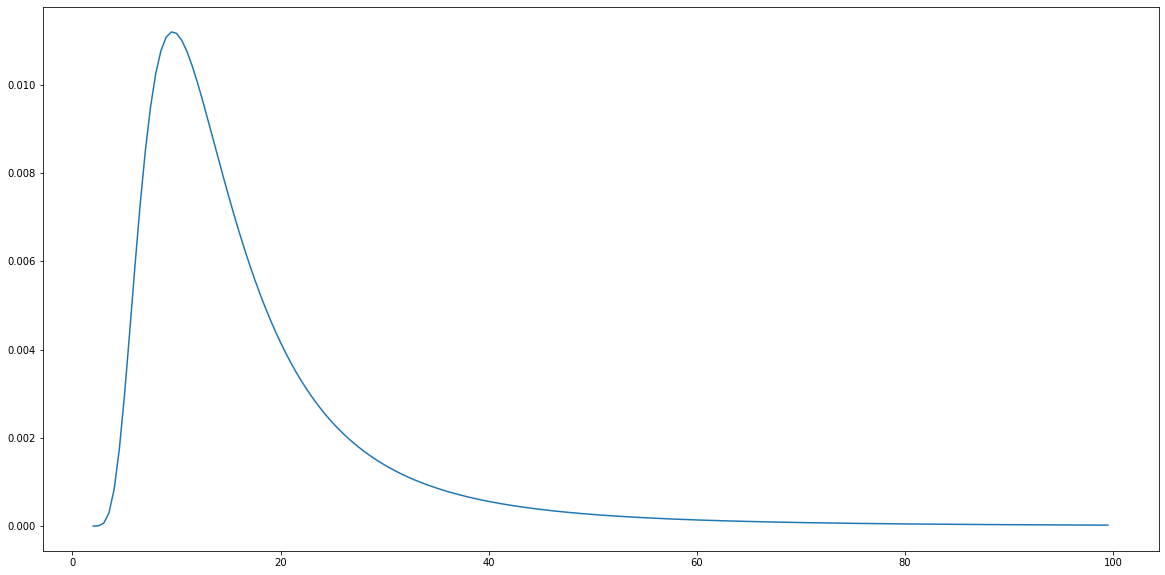

In [0]:
lamR=np.arange(2,100,.5);
plt.plot(lamR,B(10**(-6)*lamR,300,.1,300,.1))

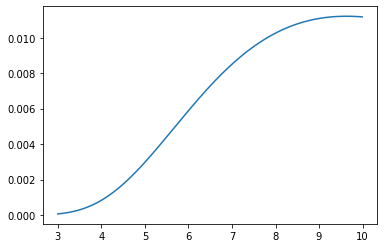

In [0]:
lamR=np.arange(3,10,.01);
plt.plot(lamR,B(10**(-6)*lamR,300,.1,300,.1))

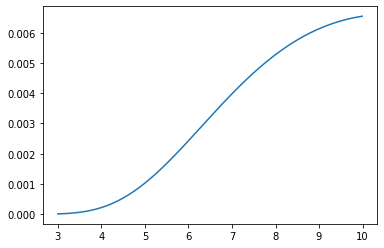

In [0]:
lamR=np.arange(3,10,.01);
plt.plot(lamR,B(10**(-6)*lamR,270,.1,300,.1))

Shown above, thermal energy is reasonable in the Long Wave, more limited in the midwave. If we measure a spectral line of width $\delta \lambda$, say  the energy in that spectral line is

In [0]:
dl=10.**-9 # 1 nm
lam = 8.*10.**-6 # 8 micorns
energy=dl*B(lam,300,.1,300,.1)
print('energy = %e'%energy)

energy = 1.025941e-11


## Broadband spectra

typical values of infrared extinction coefficients:

Extinction coefficient, b

3-5 microns
6.7 x 10-5 m-1

8-12 microns
2.0 x 10-4 m-1






(0.0, 1.0)

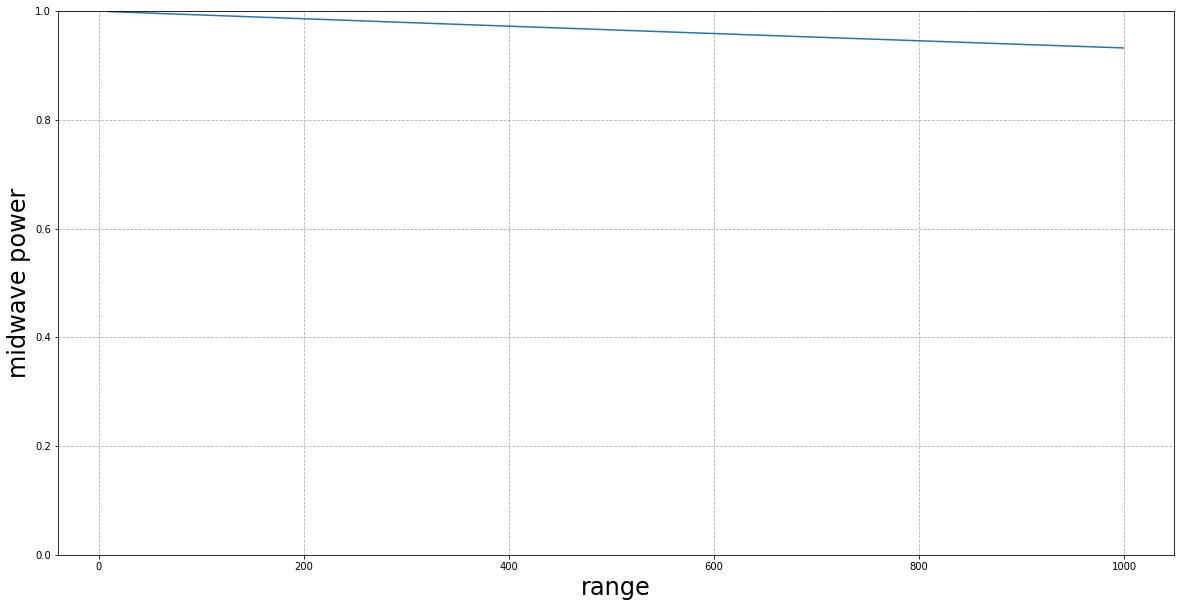

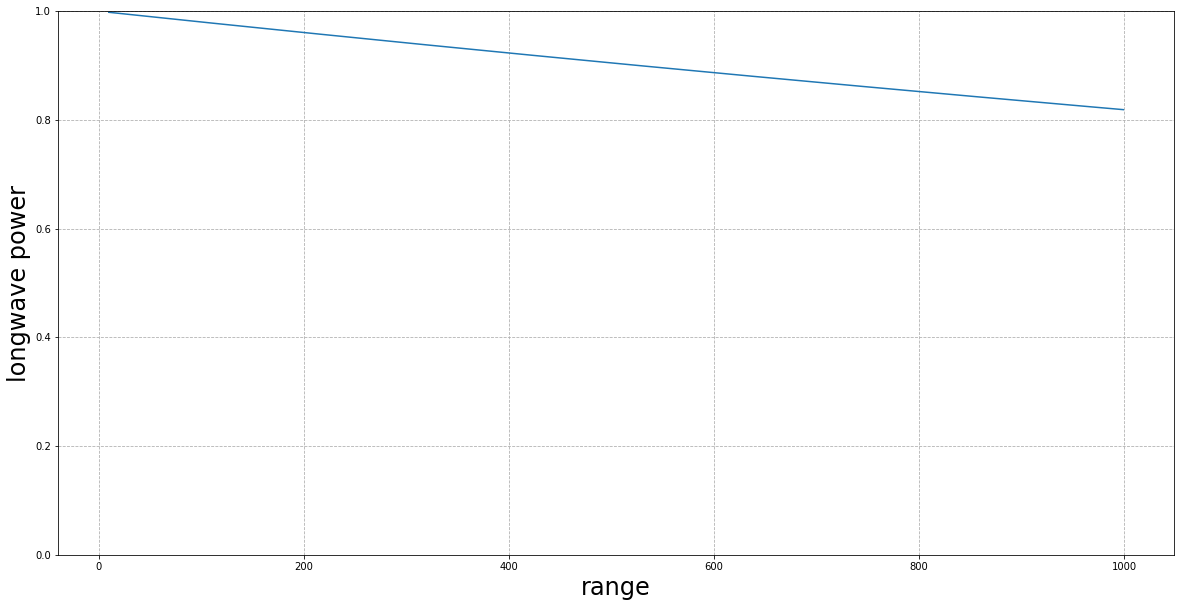

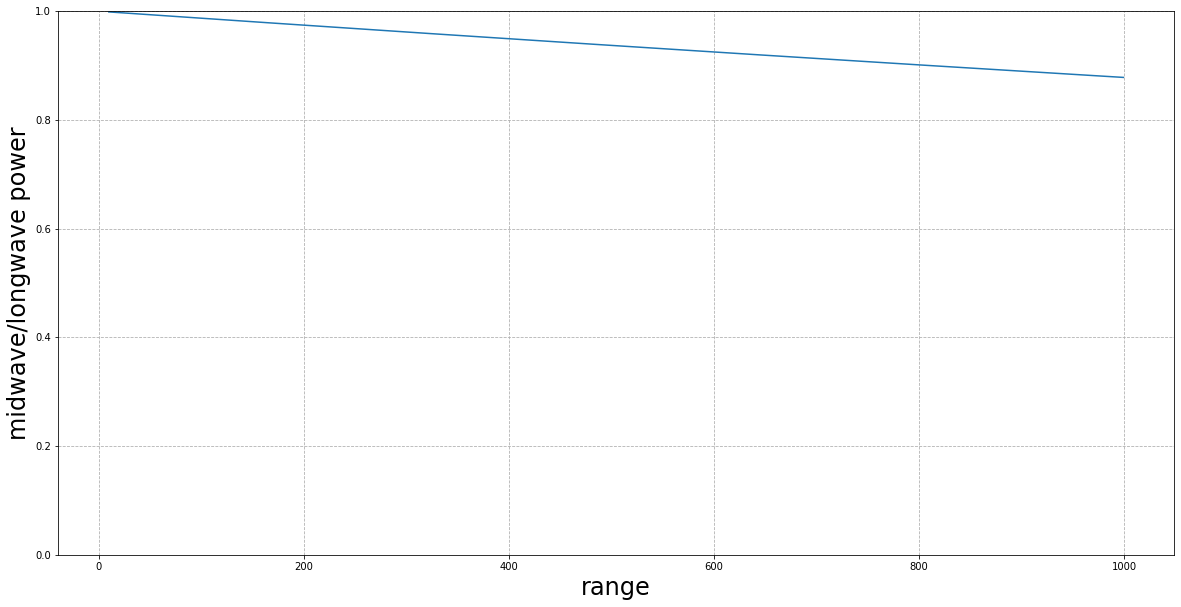

In [0]:
# relative extinction of lw and midw wave vs range
mwb=7.*10.**(-5);
lwb=2.*10**(-4);
zrange=np.arange(10,1000,1)
fig = plt.figure()
plt.plot(zrange,np.exp(-mwb*zrange))
plt.xlabel('range',fontsize=24)
plt.ylabel('midwave power',fontsize=24)
plt.grid(linestyle='--')
plt.ylim(0, 1)
fig = plt.figure()
plt.plot(zrange,np.exp(-lwb*zrange))
plt.xlabel('range',fontsize=24)
plt.ylabel('longwave power',fontsize=24)
plt.grid(linestyle='--')
plt.ylim(0, 1)
fig = plt.figure()
plt.plot(zrange,np.exp(-(lwb-mwb)*zrange))
plt.xlabel('range',fontsize=24)
plt.ylabel('midwave/longwave power',fontsize=24)
plt.grid(linestyle='--')
plt.ylim(0, 1)


range estimation from a single wavelength requires substantial dynamic range. Next we consider the dependance on the hyperspectral transmission spectrum on range. 

## infrared absorption spectra
spectral down loaded from 
https://www.gemini.edu/observing/telescopes-and-sites/sites#Transmission

extinction coefficients estimated by assuming airmass above mauna kea is 10 km thick

### download spectra

In [8]:
!wget http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_zm_50_10.dat
!wget http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_nq_50_10.dat
!ls

--2020-05-06 18:16:13--  http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_zm_50_10.dat
Resolving www.gemini.edu (www.gemini.edu)... 128.171.188.185
Connecting to www.gemini.edu (www.gemini.edu)|128.171.188.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196485 (5.0M) [application/x-troff]
Saving to: ‘mktrans_zm_50_10.dat.1’

mktrans_zm_50_10.da 100%[===================>]   4.96M  2.89MB/s    in 1.7s    

2020-05-06 18:16:16 (2.89 MB/s) - ‘mktrans_zm_50_10.dat.1’ saved [5196485/5196485]

--2020-05-06 18:16:16--  http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_nq_50_10.dat
Resolving www.gemini.edu (www.gemini.edu)... 128.171.188.185
Connecting to www.gemini.edu (www.gemini.edu)|128.171.188.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4134842 (3.9M)
Saving to: ‘mktrans_nq_50_10.dat.1’

mktrans_nq_50_10.da 100%[===================>]   3.94M  2.39MB/s    in 1.7s    

2020-05-06 1

In [9]:
midwaveSpectrum = pd.read_table('./mktrans_zm_50_10.dat', sep='\s+', names=['wavelength','attenuation'])
midwaveSpectrum['coefficient']= np.log(midwaveSpectrum['attenuation']+10**(-10))/10000.
print(midwaveSpectrum)

        wavelength  attenuation   coefficient
0          0.90000     0.997119 -2.885158e-07
1          0.90002     0.997048 -2.956366e-07
2          0.90004     0.997117 -2.887164e-07
3          0.90006     0.996095 -3.912644e-07
4          0.90008     0.994900 -5.113049e-07
...            ...          ...           ...
234995     5.59990     0.015020 -4.198393e-04
234996     5.59992     0.014688 -4.220711e-04
234997     5.59994     0.014295 -4.247845e-04
234998     5.59996     0.013891 -4.276493e-04
234999     5.59998     0.013446 -4.309074e-04

[235000 rows x 3 columns]


In [10]:
longwaveSpectrum = pd.read_table('./mktrans_nq_50_10.dat', sep='\s+', names=['wavelength','attenuation'])
longwaveSpectrum['coefficient']= np.log(longwaveSpectrum['attenuation']+10**(-10))/10000.
print(longwaveSpectrum)

        wavelength   attenuation  coefficient
0           7.0000  6.347910e-04    -0.000736
1           7.0001  5.403920e-04    -0.000752
2           7.0002  4.166090e-04    -0.000778
3           7.0003  2.899340e-04    -0.000815
4           7.0004  1.781150e-04    -0.000863
...            ...           ...          ...
189996     25.9996  0.000000e+00    -0.002303
189997     25.9997  0.000000e+00    -0.002303
189998     25.9998  0.000000e+00    -0.002303
189999     25.9999  0.000000e+00    -0.002303
190000     26.0000  1.000000e-18    -0.002303

[190001 rows x 3 columns]


In [11]:
longwaveSpectrum.mean()

wavelength     16.500000
attenuation     0.445407
coefficient    -0.000531
dtype: float64

In [12]:
midwaveSpectrum.mean()

wavelength     3.249990
attenuation    0.593630
coefficient   -0.000393
dtype: float64

## hyperspectral analysis

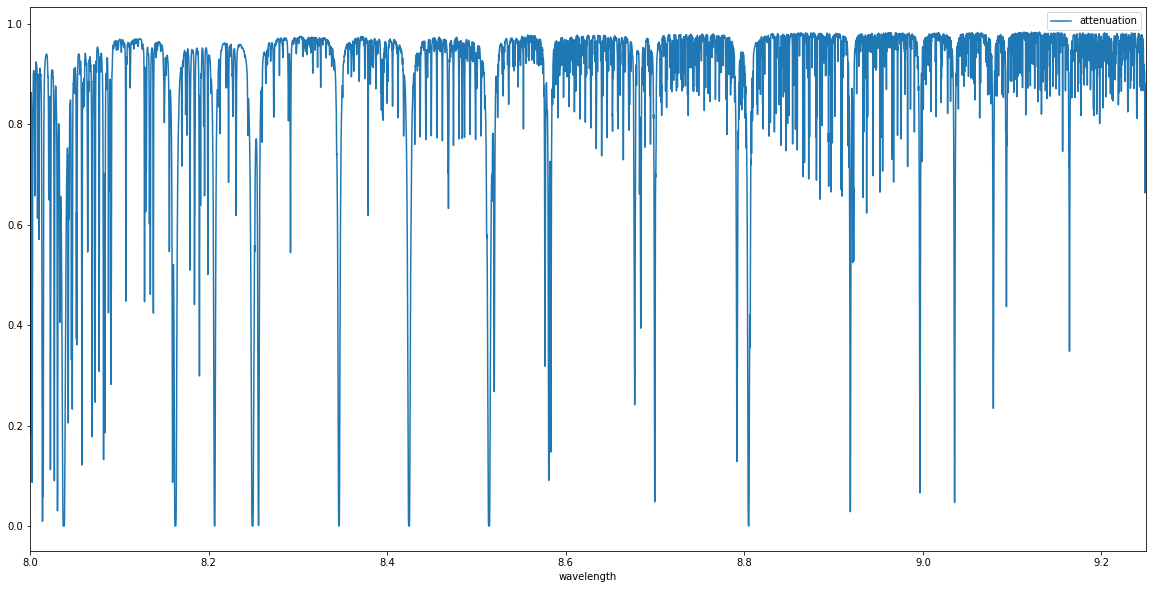

In [0]:
ax = plt.gca()

longwaveSpectrum.plot(kind='line',x='wavelength',y='attenuation',xlim=(8,9.25),ax=ax)

plt.show()

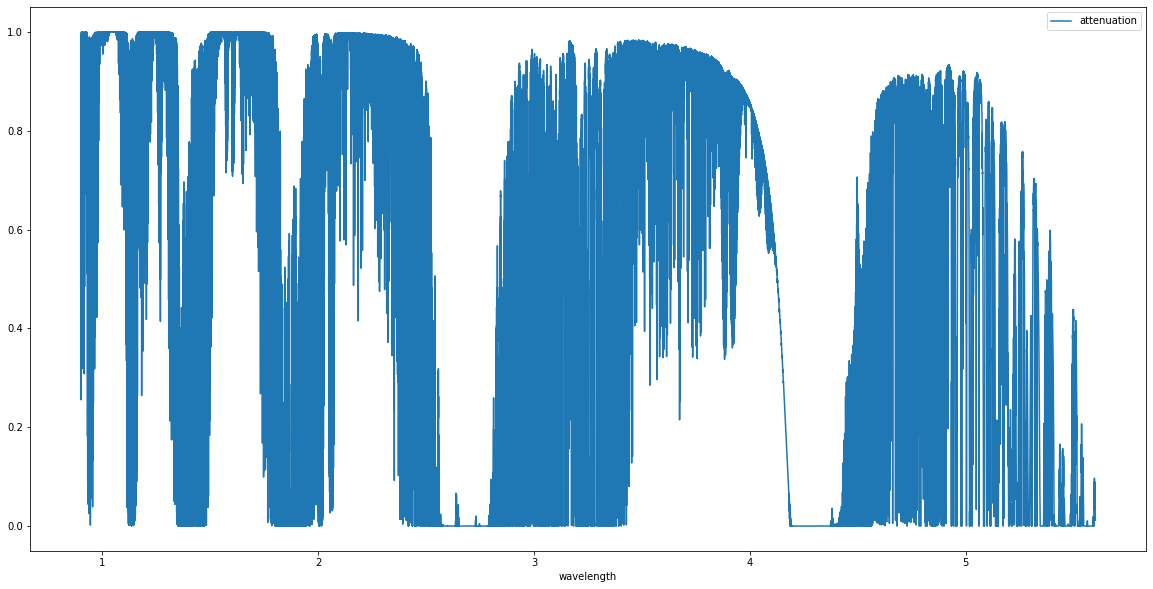

In [0]:
ax = plt.gca()

midwaveSpectrum.plot(kind='line',x='wavelength',y='attenuation',ax=ax)

plt.show()

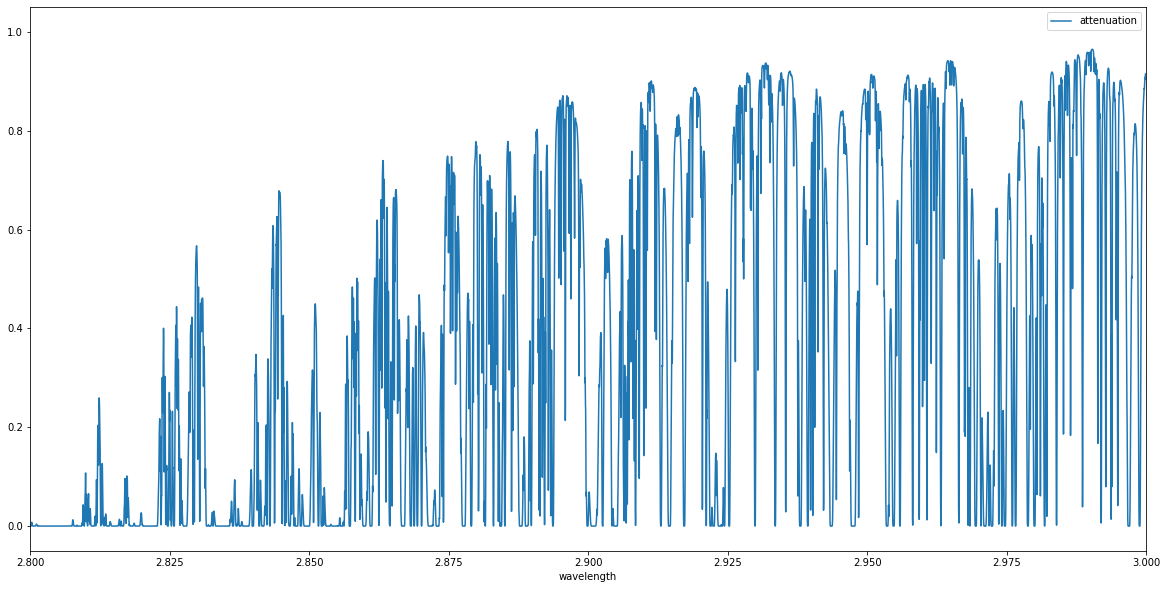

In [0]:
ax = plt.gca()

midwaveSpectrum.plot(kind='line',x='wavelength',y='attenuation',xlim=(2.8,3),ax=ax)

plt.show()

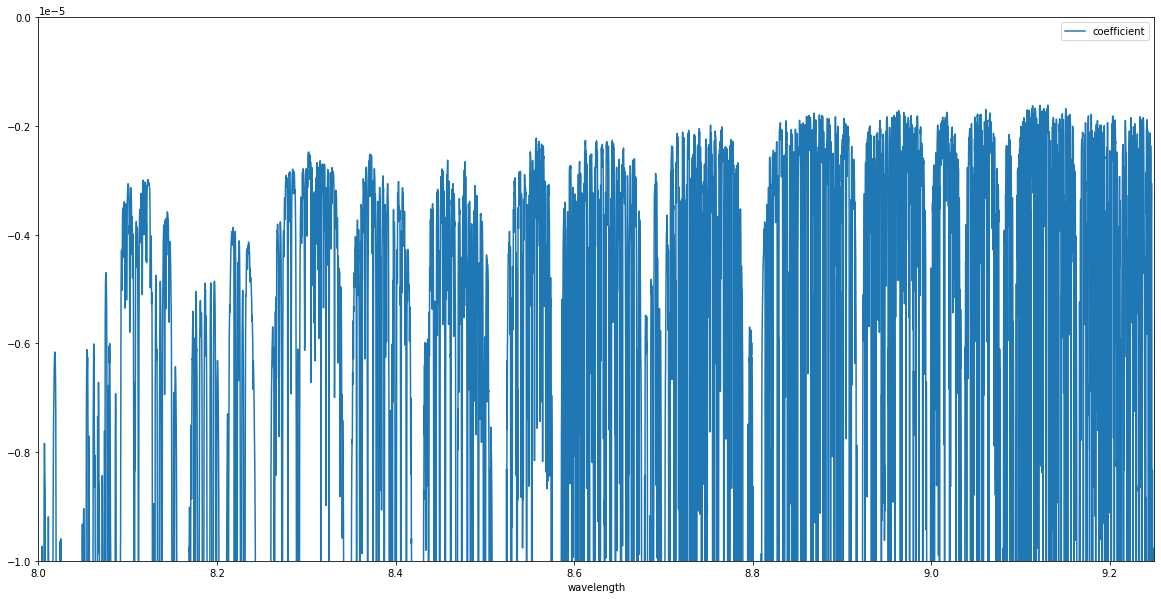

In [0]:
ax = plt.gca()

longwaveSpectrum.plot(kind='line',x='wavelength',y='coefficient',ax=ax, xlim=(8,9.25),ylim=(-.00001,0))


plt.show()

In [0]:
longwaveSpectrum['100meters']=np.exp(longwaveSpectrum['coefficient']*100)
longwaveSpectrum['300meters']=np.exp(longwaveSpectrum['coefficient']*300)
longwaveSpectrum['1000meters']=np.exp(longwaveSpectrum['coefficient']*1000)

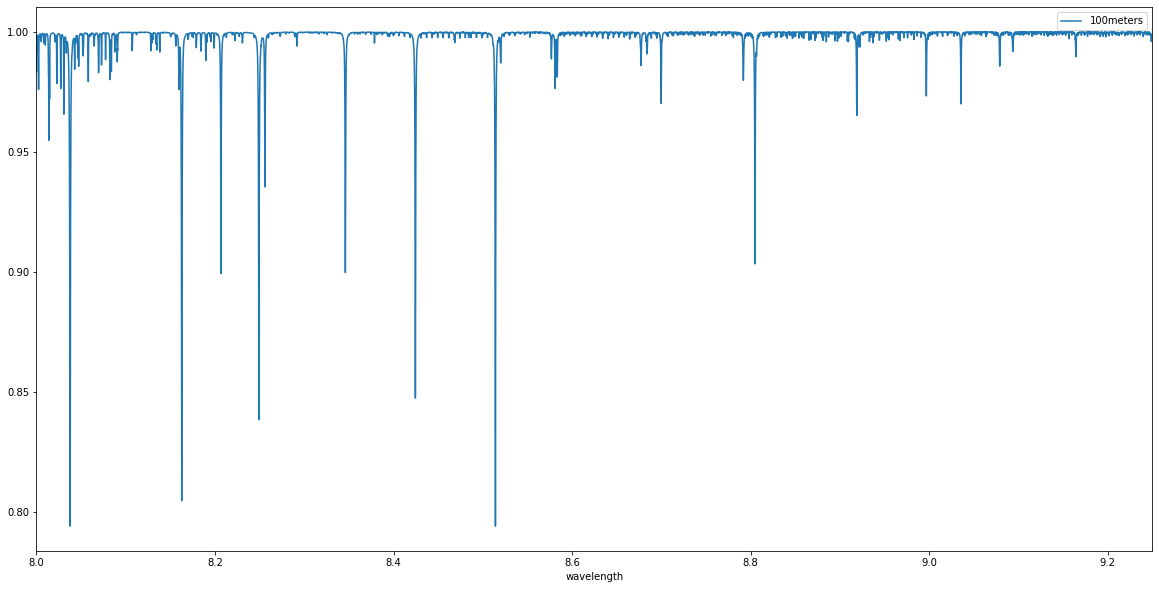

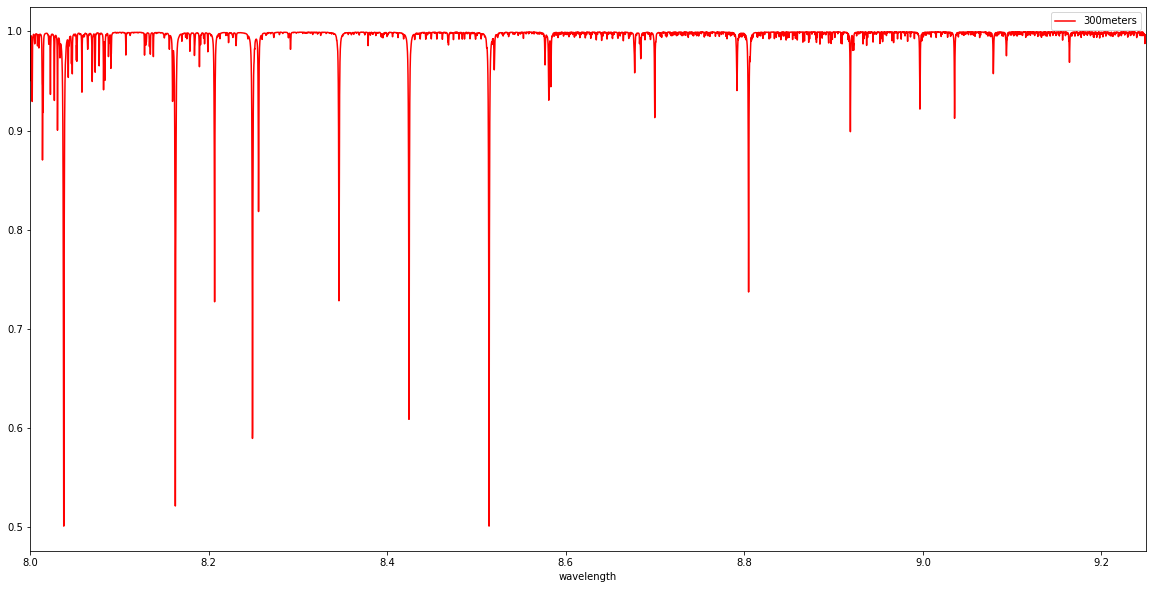

In [0]:
ax = plt.gca()

longwaveSpectrum.plot(kind='line',x='wavelength',y='100meters',xlim=(8,9.25),ax=ax)
#longwaveSpectrum.plot(kind='line',x='wavelength',y='300meters',color='red',xlim=(8,9.25),ax=ax)
#longwaveSpectrum.plot(kind='line',x='wavelength',y='1000meters',color='green',xlim=(8,9.25),ax=ax)

plt.show()
plt.figure
ax=plt.gca()

#longwaveSpectrum.plot(kind='line',x='wavelength',y='100meters',xlim=(8,9.25),ax=ax)
longwaveSpectrum.plot(kind='line',x='wavelength',y='300meters',color='red',xlim=(8,9.25),ax=ax)
#longwaveSpectrum.plot(kind='line',x='wavelength',y='1000meters',color='green',xlim=(8,9.25),ax=ax)

plt.show()

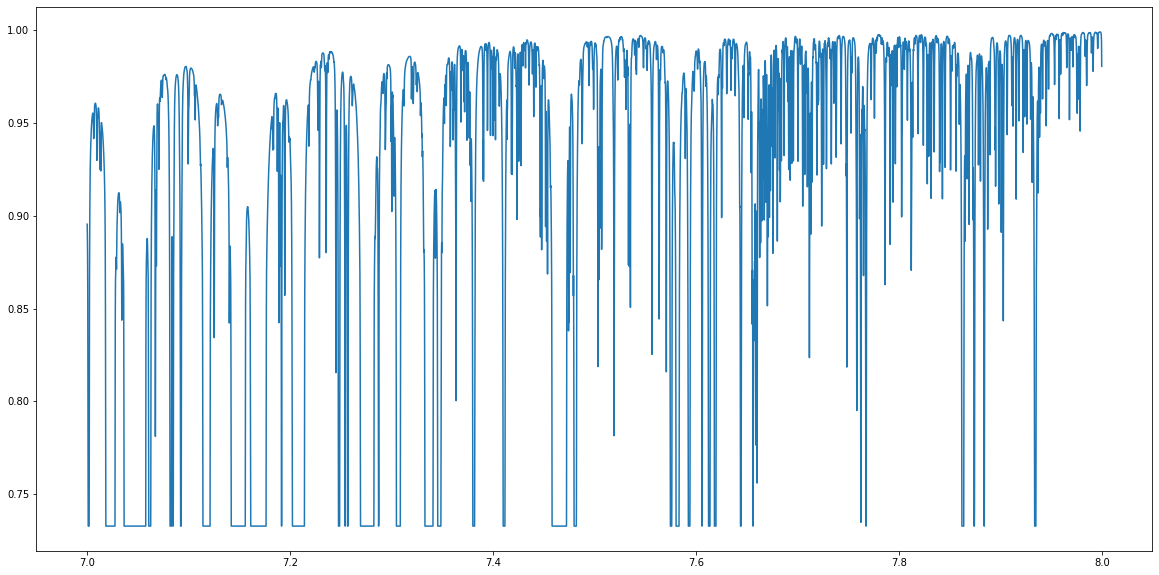

In [0]:
plt.plot(longwaveSpectrum['wavelength'][0:10000],longwaveSpectrum['300meters'][0:10000])

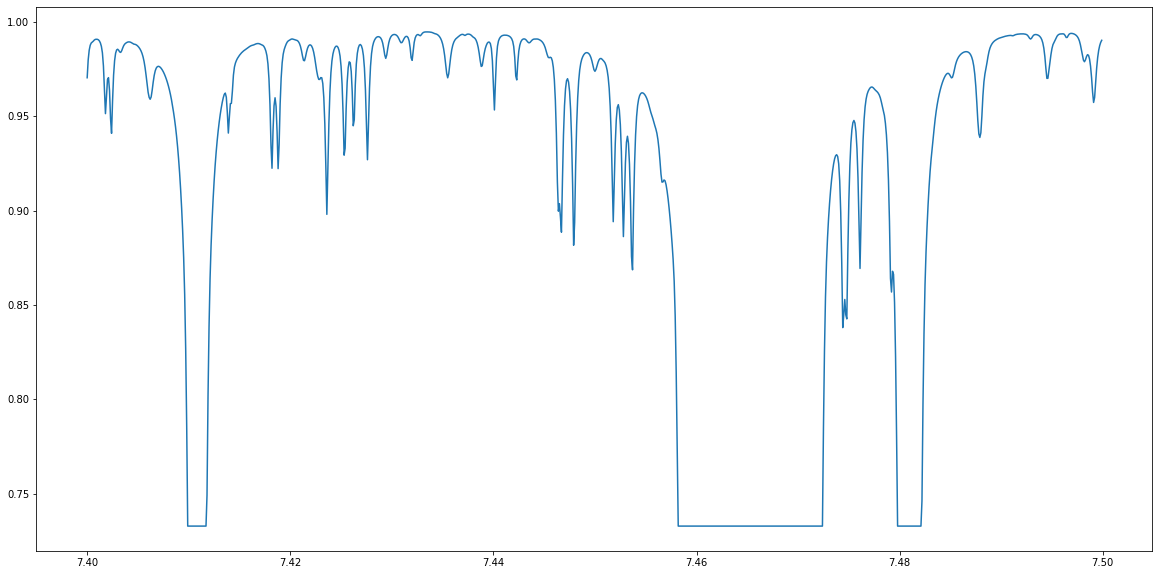

In [0]:
plt.plot(longwaveSpectrum['wavelength'][4000:5000],longwaveSpectrum['300meters'][4000:5000])

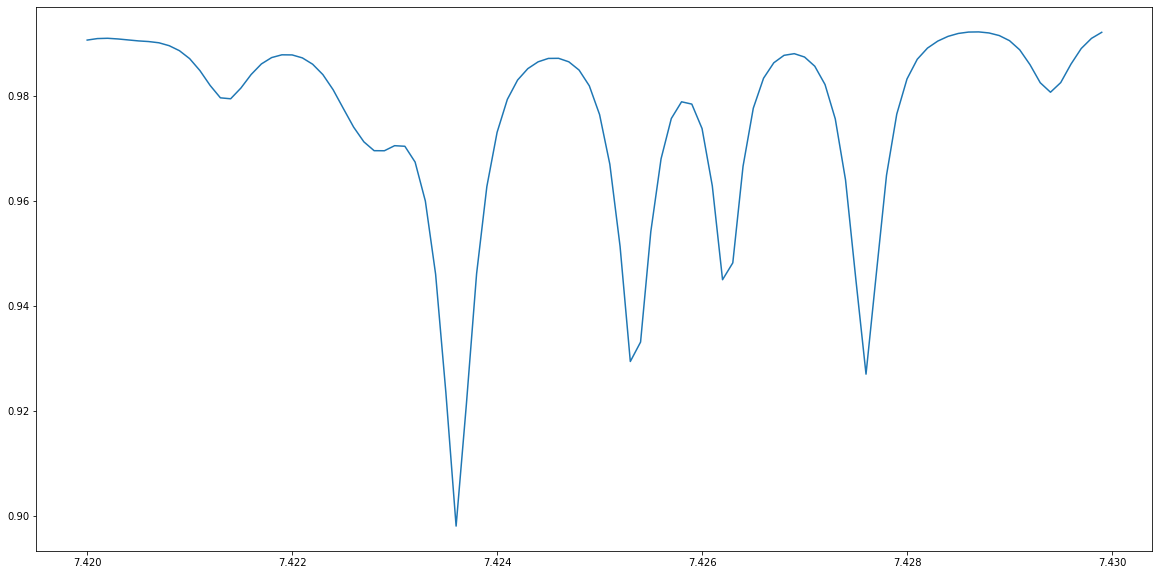

In [0]:
plt.plot(longwaveSpectrum['wavelength'][4200:4300],longwaveSpectrum['300meters'][4200:4300])

the horizontal axis above is in microns. Clearly there are features in the spectrum down to nanometer size. 

In [0]:
absorptionImage=np.zeros((100,10000),dtype=float)
for ct in range(100):
  pip=ct*500./100.
  absorptionImage[ct,:]=np.exp(longwaveSpectrum['coefficient'][0:10000]*pip)

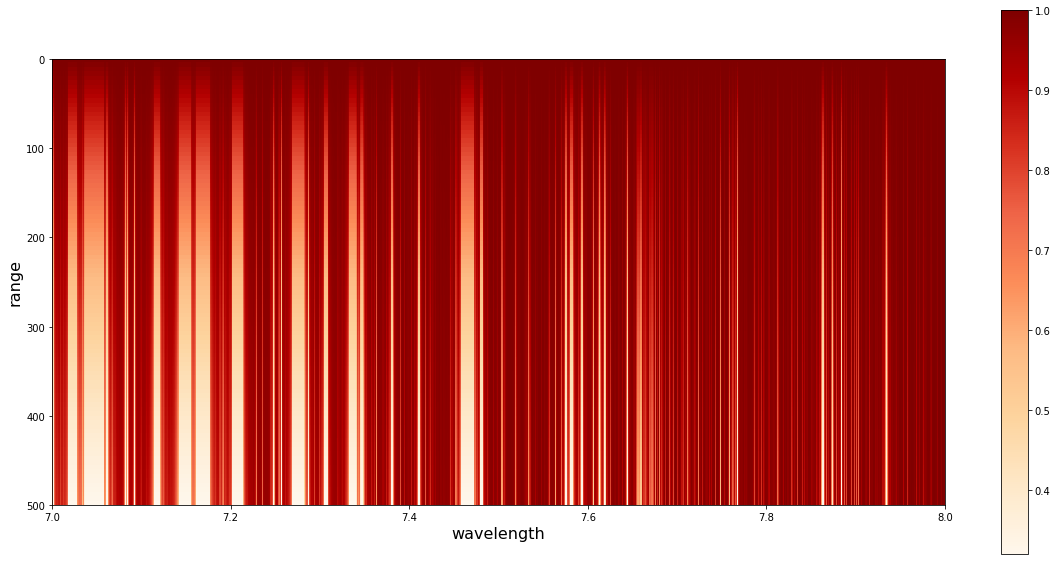

In [15]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=0.001,extent=[7,8,500,0])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()

In [0]:
pca = PCA(n_components=20)
pop=pca.fit(absorptionImage)


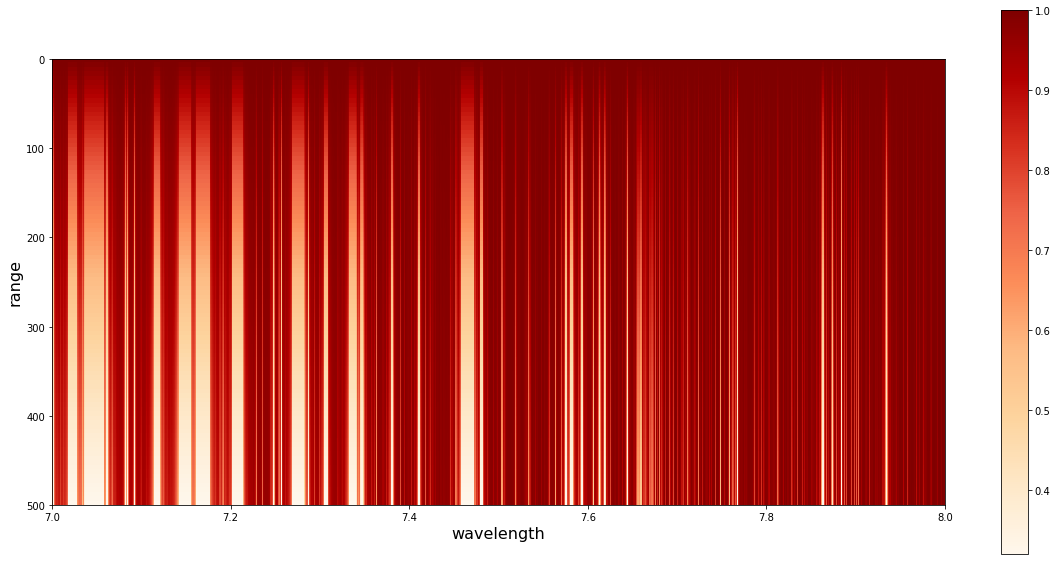

In [0]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=0.001,extent=[7,8,500,0])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()

In [17]:
print(pca.singular_values_)

[8.79562488e+01 3.74112990e+00 6.08060297e-02 9.25145391e-04
 1.18546883e-05 1.32867112e-07 1.26452052e-09 1.05716038e-11
 2.50842908e-13 7.76985311e-14 8.78859473e-15 8.78859473e-15
 8.78859473e-15 8.78859473e-15 8.78859473e-15 8.78859473e-15
 8.78859473e-15 8.78859473e-15 8.78859473e-15 8.78859473e-15]


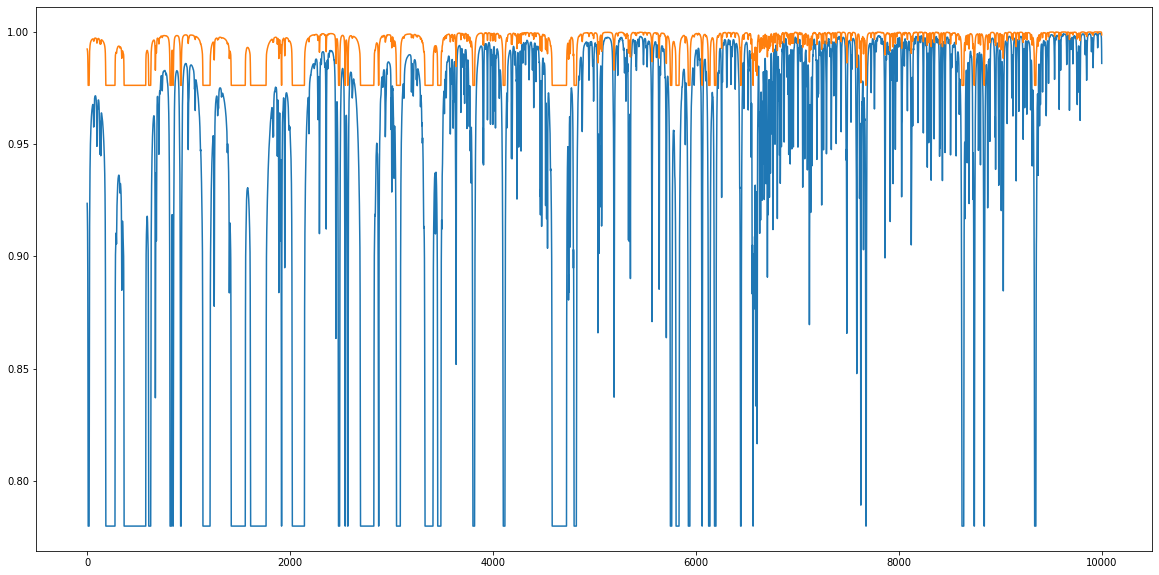

In [0]:
plt.plot(absorptionImage[200,:])
plt.plot(absorptionImage[1,:])

Principal component analysis is a powerful tool in analyzing the sensing capability of a system. Roughly, the number of distinct states that can be distinguished in the system is the dynamic range, times the number of states. For the absorption signal, the dominant mode will be dc. Differential spectroscopy around selected critical lines will be more informative. 

In [0]:
u, s, vh = np.linalg.svd(absorptionImage)

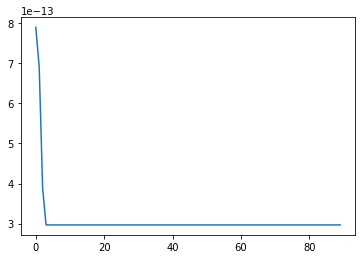

In [0]:
plt.plot(s[10:100])

svd of full spectrum is not very promissing, dominated by broad transmission features, what if we consider the inverse spectrum

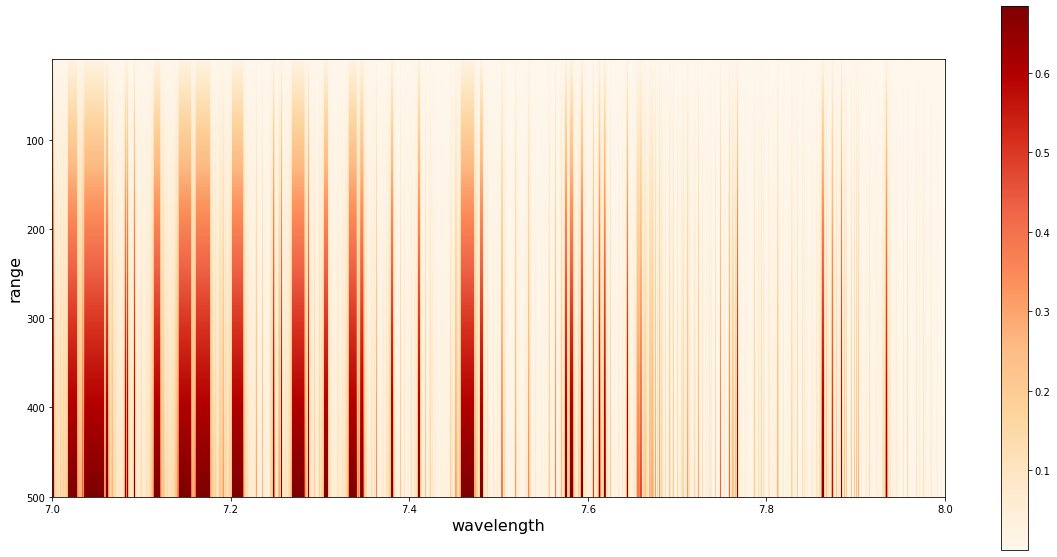

In [0]:
plt.imshow(1.-absorptionImage,cmap='OrRd',interpolation='none',aspect=0.001,extent=[7,8,500,10])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()

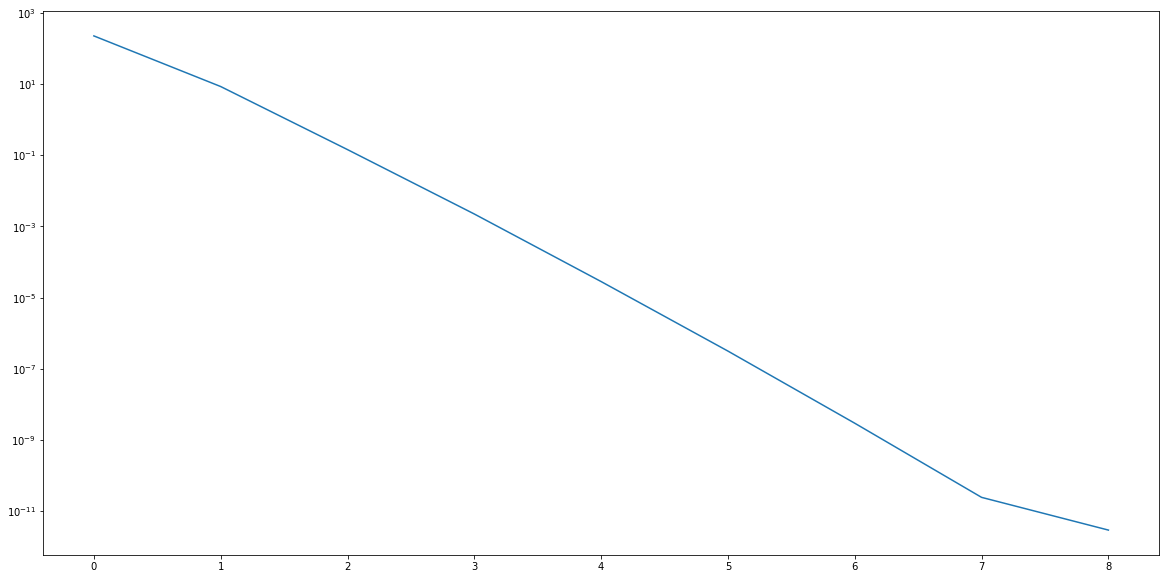

In [0]:
u, s, vh = np.linalg.svd(absorptionImage)
plt.semilogy(s[0:10])

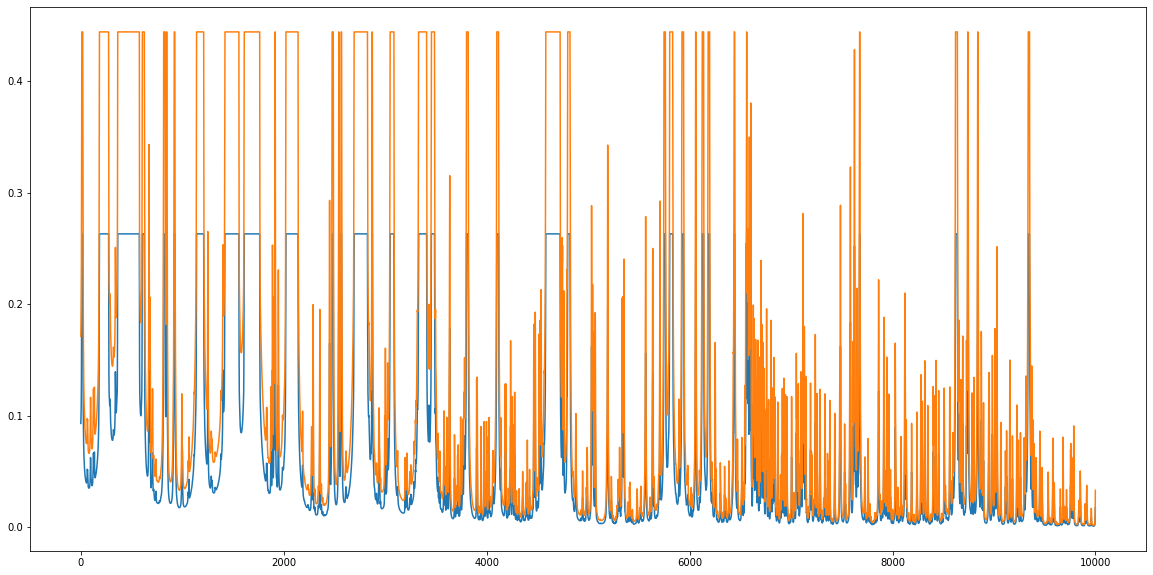

In [0]:
plt.plot(1-absorptionImage[250,:])
plt.plot(1-absorptionImage[500,:])

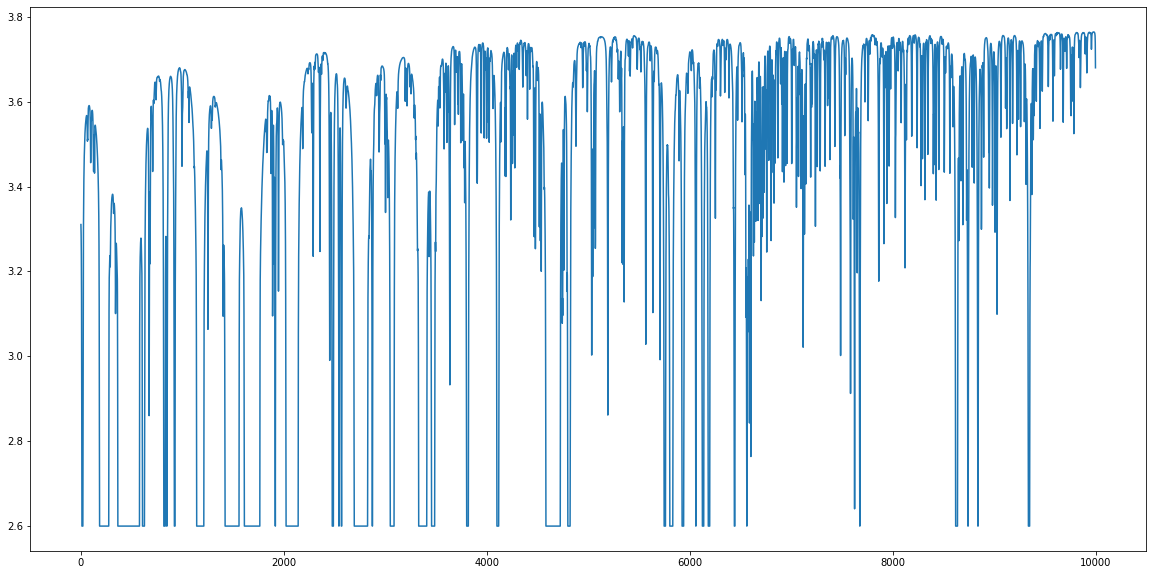

In [0]:
plt.plot((1-absorptionImage[999,:])/(1-absorptionImage[250,:]))

In [0]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=0.001,extent=[7,8,500,10])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()

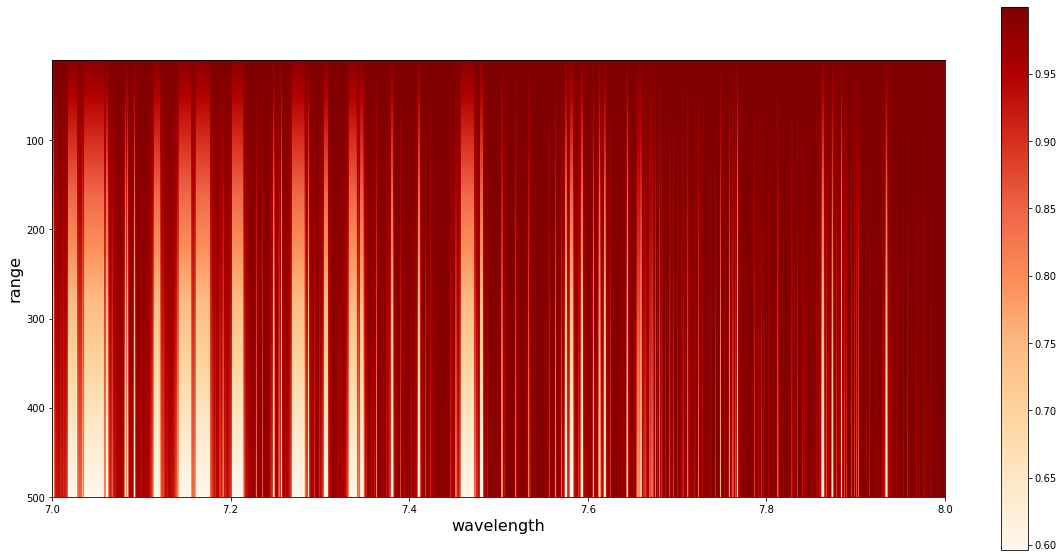

In [0]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=0.001,extent=[7,8,500,10])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()



In [0]:
absorptionImage=np.zeros((1000,1000),dtype=float)
for ct in range(1000):
  pip=10.+ct*490./1000.
  absorptionImage[ct,:]=np.exp(longwaveSpectrum['coefficient'][4000:5000]*pip)

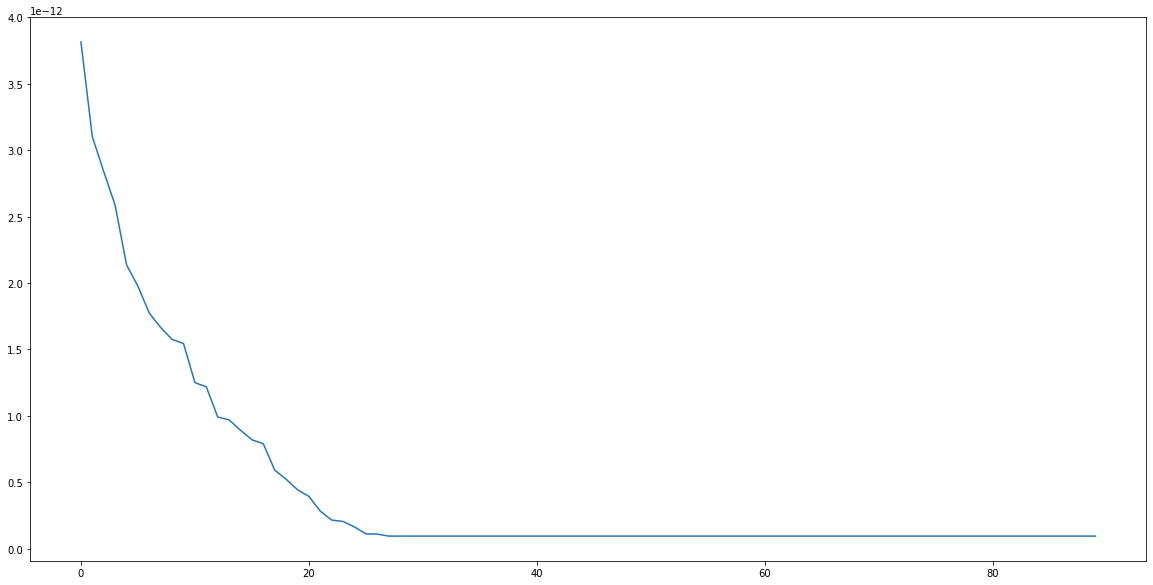

In [0]:
u, s, vh = np.linalg.svd(absorptionImage)
plt.plot(s[10:100])

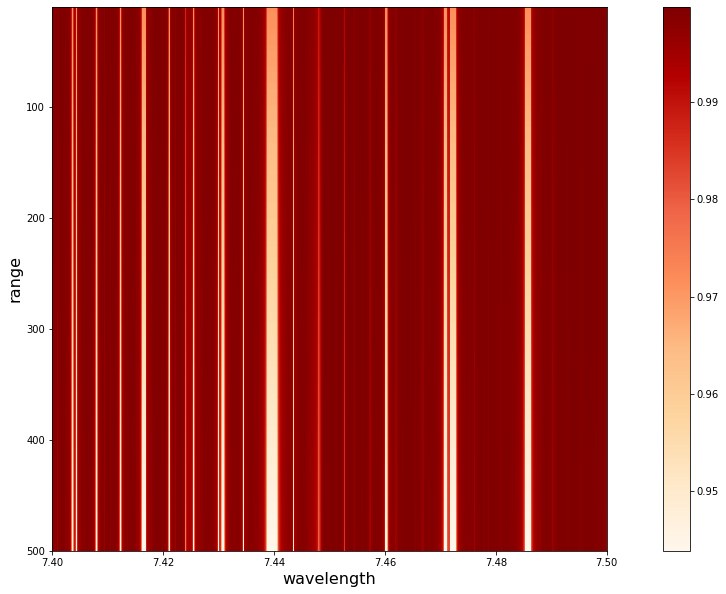

In [0]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=.0002,extent=[7.4,7.5,500,10])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()

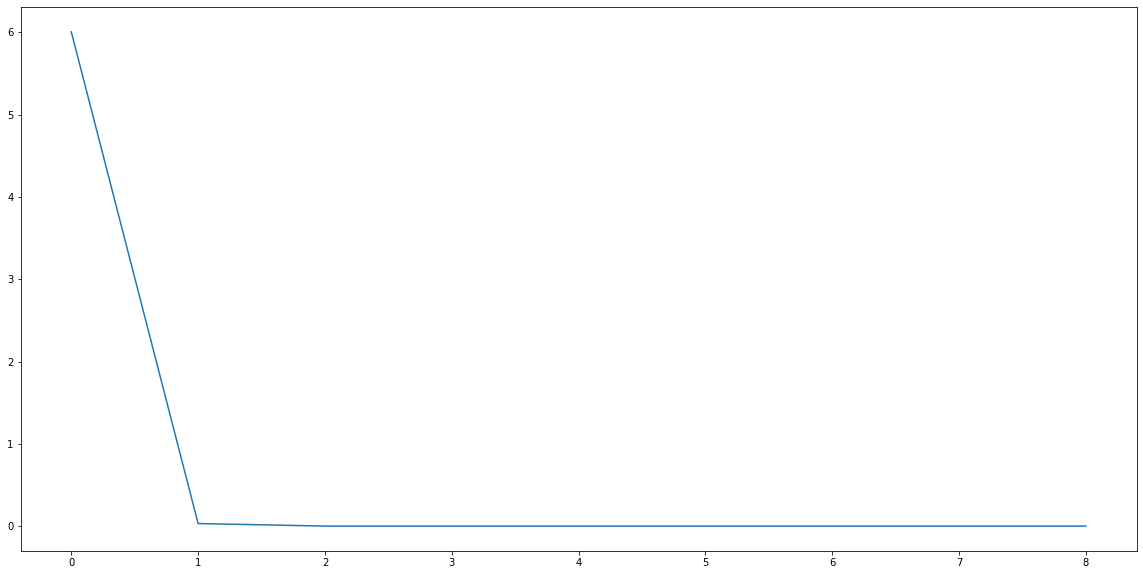

In [0]:
absorptionImage=np.zeros((100,1000),dtype=float)
for ct in range(100):
  pip=200.+ct*200./100.
  absorptionImage[ct,:]=np.exp(longwaveSpectrum['coefficient'][0:1000]*pip)
u, s, vh = np.linalg.svd(absorptionImage)
plt.plot(s[1:10])

In [0]:
def LWrangeSpectrum(lam1,lam2,range):
  # absorption spectrum as at range between lam1 in microns lam2 in microns lam1>7, lam2 <25
  l1=np.int((lam1-7)*10000); l2=np.int((lam2-7)*10000);
  sp=np.exp(longwaveSpectrum['coefficient'][l1:l2]*range)
  return sp

<function matplotlib.pyplot.show>

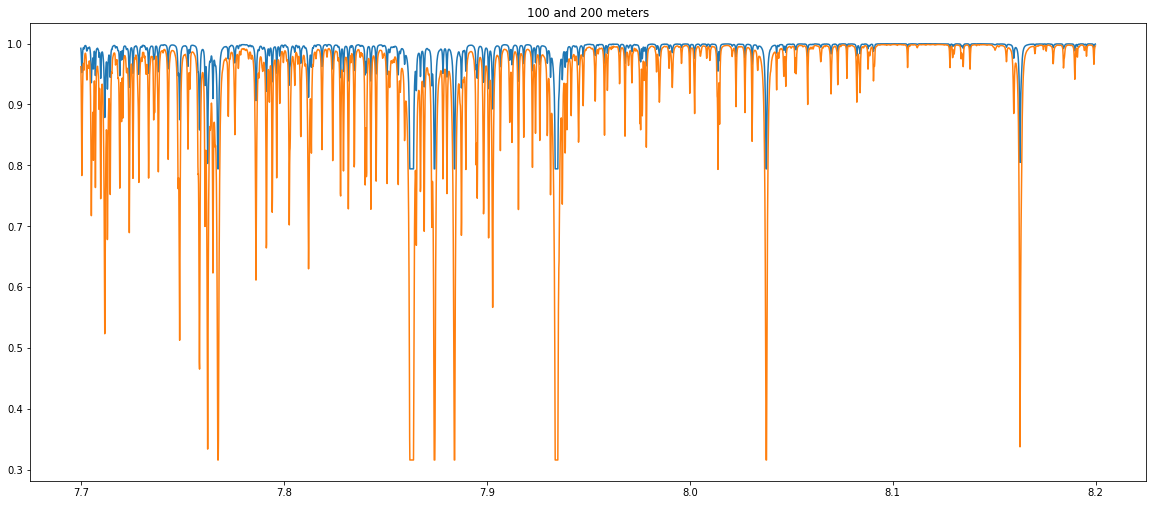

In [27]:
l1=7.7;l2=8.2;
plt.plot(longwaveSpectrum['wavelength'][np.int((l1-7)*10000):np.int((l2-7)*10000)],LWrangeSpectrum(l1,l2,100))
plt.plot(longwaveSpectrum['wavelength'][np.int((l1-7)*10000):np.int((l2-7)*10000)],LWrangeSpectrum(l1,l2,500))
plt.axes().set_aspect(.3)
plt.title('100 and 200 meters')
plt.show

It is interesting to consider whether or not there are periodic features in the spectrum. Such features are relatively easy to multiplex

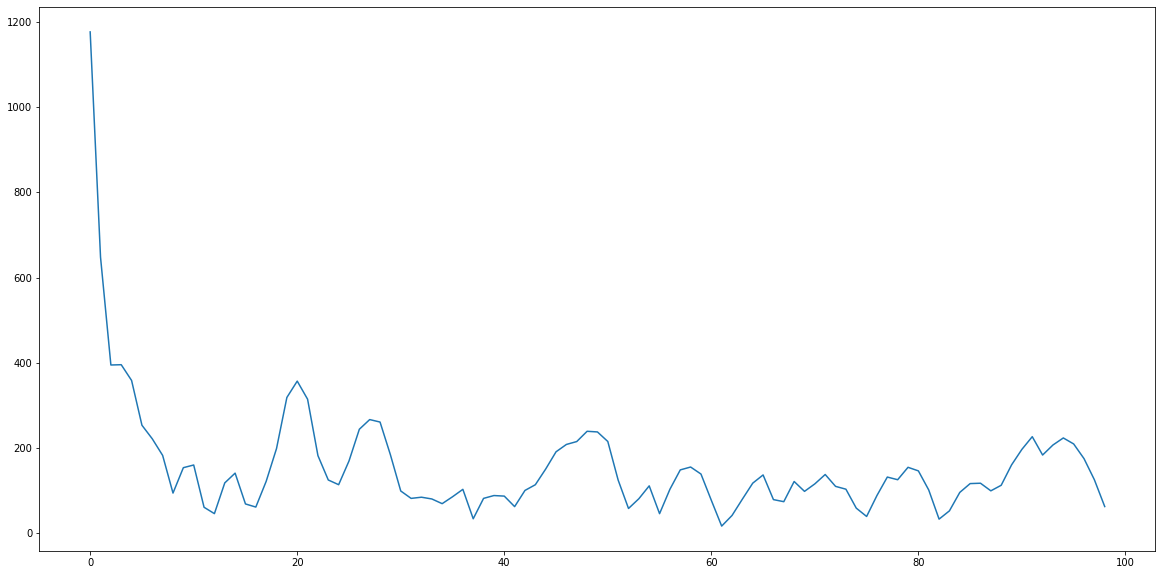

In [29]:
l1=7.;l2=10.;
plt.plot(np.abs(np.fft.fft(LWrangeSpectrum(l1,l2,300)))[1:100])

(1.0, 1.2)

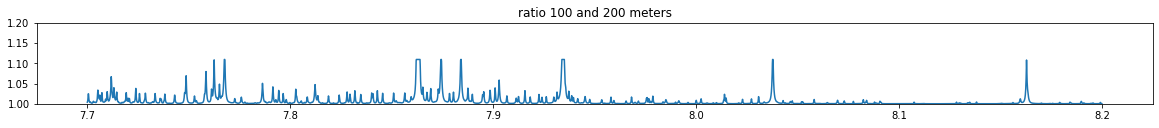

In [0]:
l1=7.7;l2=8.2;
plt.plot(longwaveSpectrum['wavelength'][np.int((l1-7)*10000):np.int((l2-7)*10000)],LWrangeSpectrum(l1,l2,100)/LWrangeSpectrum(l1,l2,200))
plt.axes().set_aspect(.2)
plt.title('ratio 100 and 200 meters')
plt.show
plt.ylim(1,1.2)


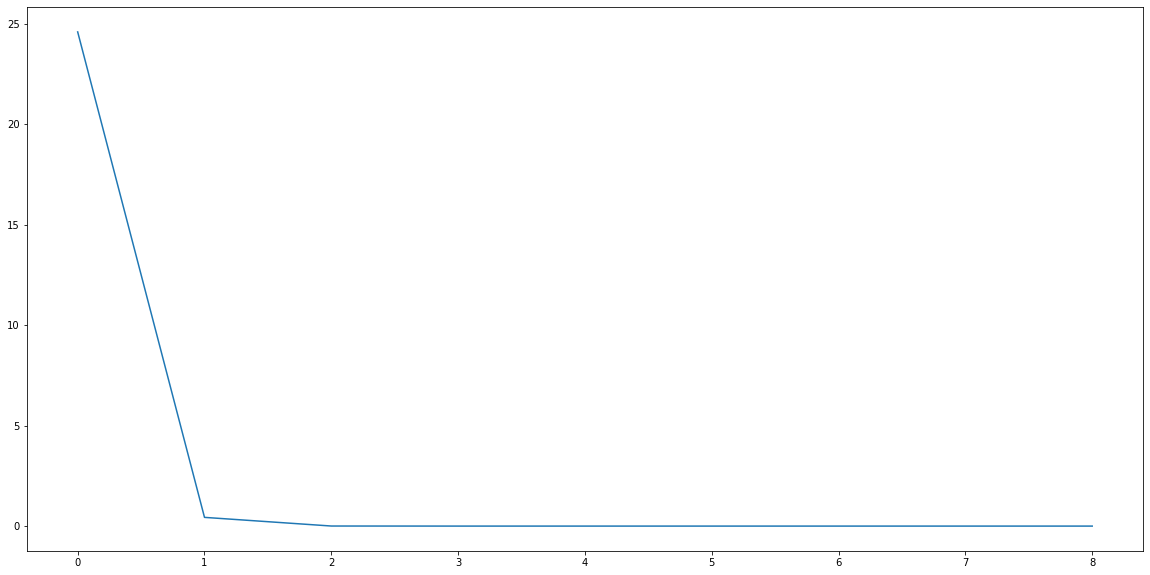

In [0]:
absorptionImage=np.zeros((100,10000),dtype=float)
for ct in range(100):
  pip=200.+ct*200./100.
  absorptionImage[ct,:]=np.exp(midwaveSpectrum['coefficient'][95000:105000]*pip)
u, s, vh = np.linalg.svd(absorptionImage)
plt.plot(s[1:10])

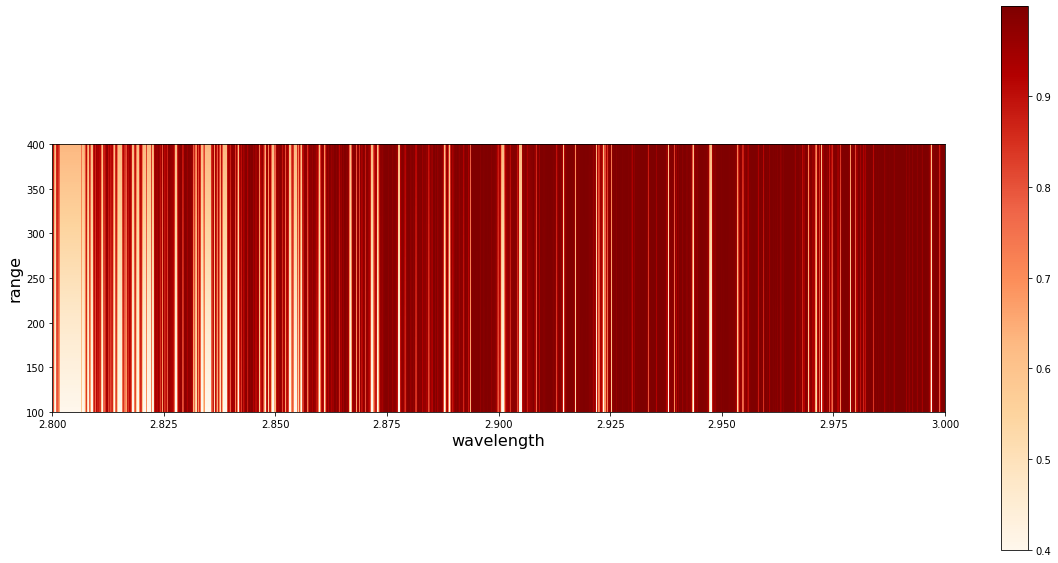

In [0]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=.0002,extent=[2.8,3.0,100,400])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()